In [1]:
# 경고 메시지가 안나오게..
import warnings
warnings.filterwarnings('ignore')

# 기본
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno

# KFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 교차 검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# 학습 데이터와 검증데이터로 나누는 함수
from sklearn.model_selection import train_test_split

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 평가함수
from sklearn.metrics import accuracy_score

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift

# 차원축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 딥러닝
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.models import Model

# 다중분류를 위한 핫-윈 인코더
from keras.utils import to_categorical

# 저장된 딥러닝 모델을 복구하는 함수
from keras.models import load_model

# epoch마다 모델을 저장하는 함수
from keras.callbacks import ModelCheckpoint

# 더이상 성능 향상이 이루어지지 않는다면 조기 중단시킬 수 있는 함수
from keras.callbacks import EarlyStopping

# 문장을 잘라준다.
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

# 저장
import pickle

# 시간 모듈
import time

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

# gpu 사용 초기화 및 할당
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
# MNIST
from keras.datasets import mnist

In [3]:
# 시드설정
np.random.seed(3)
tf.random.set_seed(3)

In [4]:
# 생성자 모델을 생성
generator = Sequential()

# 첫번째 은닉층(입력층 포함)
# 128은 임의로 정한 노드의 개수
# input_dim : 100차원 크기의 랜덤 벡터를 준비해라
# 7*7 : 최초로 생성되는 이미지의 크기
# UpSampling2D를 두 번 사용했으므로 7*7 -> 14*14 -> 28*28

generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())

# 컨볼루션 레이어(CNN)이 작업할 수 있는 형태로 데이터를 변환한다
generator.add(Reshape((7, 7, 128)))

# 두배로 증가
generator.add(UpSampling2D())

# CNN학습(padding='same'을 설정하여 CNN학습시 작아지는 것을 방지한다)
generator.add(Conv2D(64, kernel_size=5, padding='same'))

# 노멀라이징
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))

# 두배로 증가
generator.add(UpSampling2D())

# CNN 학습
# 판별자가 보고 판단하기 때문에 활성함수가 tanh로 끝나도 됨
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [5]:
# 판별자
discriminator = Sequential()
# CNN 학습
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
# CNN  학습
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
# 예측 결과 추출을 위해 1차원으로 변환한다.
discriminator.add(Flatten())
# 출력층
discriminator.add(Dense(1, activation='sigmoid'))

In [6]:
# 판별자 컴파일
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# 학습을 방지한다 - 가짜 이미지 학습이 일어나지 않도록!!
discriminator.trainable = False

### 실제로 학습은 생성자와 판별자를 연결시키는 걸로 함
### 판별자 자체는 학습을 하지 않음

In [7]:
# 생성자와 판별자를 연결시키는 gan 모델을 생성한다
# 생성자
# 임의의 벡터 100개를 생성
ginput = Input(shape=(100,))
# 판별자
dis_output = discriminator(generator(ginput))

In [8]:
# GAN 모델 생성
gen = Model(ginput, dis_output)

In [9]:
gen.compile(loss='binary_crossentropy', optimizer='adam')
gen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [10]:
# MNIST 데이터 불러오기
# GAN은 주어진 이미지를 학습해 새로운 이미지를 만드는 것이므로
# 이미지만 필요하다.
(X_train, _), (_, _) = mnist.load_data()
# 하나의 벡터로 변환한다.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# 학습용 데이터 노멀라이징(색상값들을 -1 ~ 1사이로 맞추는 작업)
# 0 ~ 1사, -1 ~ 1 등등
X_train = (X_train - 127.5) / 127.5
X_train

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [11]:
# 잘 만들어진 이미지 정보를 가질 행렬
true = np.ones((32, 1))
# 가짜 이미지 정보를 가질 행렬
fake = np.zeros((32, 1))

epoch : 0, d_loss = 0.4414430409669876, g_loss : 1.8275202512741089
epoch : 1, d_loss = 0.423652246594429, g_loss : 1.491068720817566
epoch : 2, d_loss = 0.300060972571373, g_loss : 2.0753333568573
epoch : 3, d_loss = 0.5545458197593689, g_loss : 1.6543856859207153
epoch : 4, d_loss = 0.4500085413455963, g_loss : 2.038447618484497
epoch : 5, d_loss = 0.37372030317783356, g_loss : 1.9330708980560303
epoch : 6, d_loss = 0.5200966894626617, g_loss : 2.0467703342437744
epoch : 7, d_loss = 0.278660848736763, g_loss : 2.345557451248169
epoch : 8, d_loss = 0.49168479442596436, g_loss : 1.9698543548583984
epoch : 9, d_loss = 0.3703324645757675, g_loss : 1.5383408069610596
epoch : 10, d_loss = 0.39166539907455444, g_loss : 1.7718024253845215
epoch : 11, d_loss = 0.43222279846668243, g_loss : 2.0744991302490234
epoch : 12, d_loss = 0.3776981383562088, g_loss : 2.0099785327911377
epoch : 13, d_loss = 0.5097736865282059, g_loss : 2.000393867492676
epoch : 14, d_loss = 0.49527353048324585, g_loss :

epoch : 118, d_loss = 0.4891762137413025, g_loss : 1.8654073476791382
epoch : 119, d_loss = 0.46872156858444214, g_loss : 1.9931292533874512
epoch : 120, d_loss = 0.5644824504852295, g_loss : 1.1868772506713867
epoch : 121, d_loss = 0.44395530223846436, g_loss : 1.3550076484680176
epoch : 122, d_loss = 0.3575880527496338, g_loss : 1.5051214694976807
epoch : 123, d_loss = 0.4319944232702255, g_loss : 2.0732345581054688
epoch : 124, d_loss = 0.48254939913749695, g_loss : 1.9981313943862915
epoch : 125, d_loss = 0.4188547432422638, g_loss : 2.326314926147461
epoch : 126, d_loss = 0.4428150802850723, g_loss : 1.7326781749725342
epoch : 127, d_loss = 0.5543151050806046, g_loss : 1.755962610244751
epoch : 128, d_loss = 0.5799768567085266, g_loss : 1.4790385961532593
epoch : 129, d_loss = 0.5923270583152771, g_loss : 1.4105188846588135
epoch : 130, d_loss = 0.4855383187532425, g_loss : 2.1716742515563965
epoch : 131, d_loss = 0.7042497396469116, g_loss : 1.6660774946212769
epoch : 132, d_loss

epoch : 237, d_loss = 0.4771738052368164, g_loss : 2.173117160797119
epoch : 238, d_loss = 0.5975521206855774, g_loss : 1.8637175559997559
epoch : 239, d_loss = 0.5127132534980774, g_loss : 1.9985294342041016
epoch : 240, d_loss = 0.5021592229604721, g_loss : 2.2599785327911377
epoch : 241, d_loss = 0.5952572226524353, g_loss : 1.7783992290496826
epoch : 242, d_loss = 0.4242567867040634, g_loss : 2.0174758434295654
epoch : 243, d_loss = 0.40061646699905396, g_loss : 1.8735662698745728
epoch : 244, d_loss = 0.6108804047107697, g_loss : 1.5143444538116455
epoch : 245, d_loss = 0.5484539270401001, g_loss : 1.6003170013427734
epoch : 246, d_loss = 0.5984579920768738, g_loss : 1.6752350330352783
epoch : 247, d_loss = 0.4665423780679703, g_loss : 2.272214651107788
epoch : 248, d_loss = 0.40577535331249237, g_loss : 2.1649370193481445
epoch : 249, d_loss = 0.5480958968400955, g_loss : 2.4635424613952637
epoch : 250, d_loss = 0.6047513037919998, g_loss : 2.3619918823242188
epoch : 251, d_loss 

epoch : 356, d_loss = 0.38526391983032227, g_loss : 1.903726577758789
epoch : 357, d_loss = 0.664310485124588, g_loss : 1.658839464187622
epoch : 358, d_loss = 0.4821365624666214, g_loss : 1.7528578042984009
epoch : 359, d_loss = 0.4384719729423523, g_loss : 2.0483713150024414
epoch : 360, d_loss = 0.5193813443183899, g_loss : 1.4689360857009888
epoch : 361, d_loss = 0.47993461787700653, g_loss : 1.4960510730743408
epoch : 362, d_loss = 0.4848490506410599, g_loss : 1.6208583116531372
epoch : 363, d_loss = 0.37530869245529175, g_loss : 1.7484426498413086
epoch : 364, d_loss = 0.6213906407356262, g_loss : 1.2386598587036133
epoch : 365, d_loss = 0.40336212515830994, g_loss : 1.536057710647583
epoch : 366, d_loss = 0.6085769534111023, g_loss : 1.715735673904419
epoch : 367, d_loss = 0.44323769211769104, g_loss : 1.5813047885894775
epoch : 368, d_loss = 0.49502338469028473, g_loss : 1.7140171527862549
epoch : 369, d_loss = 0.513974666595459, g_loss : 1.678268313407898
epoch : 370, d_loss =

epoch : 475, d_loss = 0.4709976613521576, g_loss : 2.2453055381774902
epoch : 476, d_loss = 0.4986473023891449, g_loss : 1.7803581953048706
epoch : 477, d_loss = 0.3648422509431839, g_loss : 1.799838662147522
epoch : 478, d_loss = 0.3988547623157501, g_loss : 1.7197940349578857
epoch : 479, d_loss = 0.40284550189971924, g_loss : 2.0536999702453613
epoch : 480, d_loss = 0.5585078299045563, g_loss : 1.729385495185852
epoch : 481, d_loss = 0.5802875757217407, g_loss : 1.4757976531982422
epoch : 482, d_loss = 0.46826833486557007, g_loss : 1.6368757486343384
epoch : 483, d_loss = 0.50344118475914, g_loss : 1.7841969728469849
epoch : 484, d_loss = 0.43579810857772827, g_loss : 1.4214959144592285
epoch : 485, d_loss = 0.4118359237909317, g_loss : 2.110598564147949
epoch : 486, d_loss = 0.4250008165836334, g_loss : 1.6502927541732788
epoch : 487, d_loss = 0.4914179593324661, g_loss : 1.9222427606582642
epoch : 488, d_loss = 0.39820238947868347, g_loss : 2.0335144996643066
epoch : 489, d_loss =

epoch : 593, d_loss = 0.37227578461170197, g_loss : 1.3839460611343384
epoch : 594, d_loss = 0.5644900500774384, g_loss : 1.2816985845565796
epoch : 595, d_loss = 0.7494349181652069, g_loss : 1.1363970041275024
epoch : 596, d_loss = 0.51605324447155, g_loss : 1.2547037601470947
epoch : 597, d_loss = 0.5558067858219147, g_loss : 1.762474536895752
epoch : 598, d_loss = 0.4976395070552826, g_loss : 1.8883506059646606
epoch : 599, d_loss = 0.6250567436218262, g_loss : 1.9674937725067139
epoch : 600, d_loss = 0.6096762418746948, g_loss : 1.7393543720245361
epoch : 601, d_loss = 0.6580968201160431, g_loss : 1.4129879474639893
epoch : 602, d_loss = 0.6646694839000702, g_loss : 1.3025741577148438
epoch : 603, d_loss = 0.4748222678899765, g_loss : 1.3838592767715454
epoch : 604, d_loss = 0.523534283041954, g_loss : 1.218140959739685
epoch : 605, d_loss = 0.3905141204595566, g_loss : 1.2936580181121826
epoch : 606, d_loss = 0.47870975732803345, g_loss : 1.7609186172485352
epoch : 607, d_loss = 0

epoch : 712, d_loss = 0.4764948636293411, g_loss : 1.8264765739440918
epoch : 713, d_loss = 0.4594501703977585, g_loss : 1.5737099647521973
epoch : 714, d_loss = 0.45225924253463745, g_loss : 1.7161451578140259
epoch : 715, d_loss = 0.3930039703845978, g_loss : 1.427056908607483
epoch : 716, d_loss = 0.637263834476471, g_loss : 1.803393840789795
epoch : 717, d_loss = 0.6111926734447479, g_loss : 2.005310535430908
epoch : 718, d_loss = 0.45891931653022766, g_loss : 1.9698619842529297
epoch : 719, d_loss = 0.5469366908073425, g_loss : 1.8490575551986694
epoch : 720, d_loss = 0.43173953890800476, g_loss : 1.7623896598815918
epoch : 721, d_loss = 0.3967984765768051, g_loss : 1.9231513738632202
epoch : 722, d_loss = 0.4844546616077423, g_loss : 2.2963662147521973
epoch : 723, d_loss = 0.34702402353286743, g_loss : 2.3416528701782227
epoch : 724, d_loss = 0.4173264652490616, g_loss : 2.0087714195251465
epoch : 725, d_loss = 0.4152865409851074, g_loss : 1.6127827167510986
epoch : 726, d_loss 

epoch : 829, d_loss = 0.389499694108963, g_loss : 1.4287389516830444
epoch : 830, d_loss = 0.5534716993570328, g_loss : 1.6725540161132812
epoch : 831, d_loss = 0.5981906950473785, g_loss : 1.7024047374725342
epoch : 832, d_loss = 0.43841399252414703, g_loss : 1.7855198383331299
epoch : 833, d_loss = 0.41054993867874146, g_loss : 2.4288578033447266
epoch : 834, d_loss = 0.4005839228630066, g_loss : 2.3446197509765625
epoch : 835, d_loss = 0.5463941395282745, g_loss : 1.9033650159835815
epoch : 836, d_loss = 0.39829006791114807, g_loss : 1.3587753772735596
epoch : 837, d_loss = 0.5024118423461914, g_loss : 1.3162562847137451
epoch : 838, d_loss = 0.6990295648574829, g_loss : 1.6176753044128418
epoch : 839, d_loss = 0.6464720666408539, g_loss : 1.2940776348114014
epoch : 840, d_loss = 0.574752926826477, g_loss : 1.5592408180236816
epoch : 841, d_loss = 0.5331706702709198, g_loss : 1.9152098894119263
epoch : 842, d_loss = 0.45098990201950073, g_loss : 2.30348539352417
epoch : 843, d_loss 

epoch : 948, d_loss = 0.5192447304725647, g_loss : 1.6253132820129395
epoch : 949, d_loss = 0.42621228098869324, g_loss : 1.874517798423767
epoch : 950, d_loss = 0.6842017471790314, g_loss : 1.6082613468170166
epoch : 951, d_loss = 0.6956378817558289, g_loss : 1.3847899436950684
epoch : 952, d_loss = 0.4464986324310303, g_loss : 1.7201462984085083
epoch : 953, d_loss = 0.49296116828918457, g_loss : 1.846372365951538
epoch : 954, d_loss = 0.650630384683609, g_loss : 1.5340478420257568
epoch : 955, d_loss = 0.44467614591121674, g_loss : 1.7164775133132935
epoch : 956, d_loss = 0.48466724157333374, g_loss : 1.9732863903045654
epoch : 957, d_loss = 0.43623119592666626, g_loss : 2.0887839794158936
epoch : 958, d_loss = 0.5632174164056778, g_loss : 1.357244849205017
epoch : 959, d_loss = 0.5227838158607483, g_loss : 1.7936310768127441
epoch : 960, d_loss = 0.5156329274177551, g_loss : 1.2388970851898193
epoch : 961, d_loss = 0.37522485852241516, g_loss : 1.3514833450317383
epoch : 962, d_los

epoch : 1067, d_loss = 0.4338497519493103, g_loss : 2.0893614292144775
epoch : 1068, d_loss = 0.8044130802154541, g_loss : 1.5763146877288818
epoch : 1069, d_loss = 0.5203225612640381, g_loss : 1.5559723377227783
epoch : 1070, d_loss = 0.5701661705970764, g_loss : 1.3964118957519531
epoch : 1071, d_loss = 0.47268325090408325, g_loss : 1.738229513168335
epoch : 1072, d_loss = 0.6566129922866821, g_loss : 1.3304409980773926
epoch : 1073, d_loss = 0.47376981377601624, g_loss : 1.8736927509307861
epoch : 1074, d_loss = 0.5065827816724777, g_loss : 1.642594337463379
epoch : 1075, d_loss = 0.5494077205657959, g_loss : 1.3025628328323364
epoch : 1076, d_loss = 0.6393529772758484, g_loss : 1.4076428413391113
epoch : 1077, d_loss = 0.5263755321502686, g_loss : 1.8410923480987549
epoch : 1078, d_loss = 0.47990596294403076, g_loss : 2.0002381801605225
epoch : 1079, d_loss = 0.42370040714740753, g_loss : 2.6003408432006836
epoch : 1080, d_loss = 0.809981107711792, g_loss : 1.8455946445465088
epoch

epoch : 1182, d_loss = 0.5681569278240204, g_loss : 1.9311705827713013
epoch : 1183, d_loss = 0.48060275614261627, g_loss : 1.6682227849960327
epoch : 1184, d_loss = 0.41885749995708466, g_loss : 1.7697683572769165
epoch : 1185, d_loss = 0.4917060434818268, g_loss : 1.6554484367370605
epoch : 1186, d_loss = 0.5240482985973358, g_loss : 1.586238980293274
epoch : 1187, d_loss = 0.5716757476329803, g_loss : 1.5954385995864868
epoch : 1188, d_loss = 0.5472297966480255, g_loss : 1.4689794778823853
epoch : 1189, d_loss = 0.4484485685825348, g_loss : 1.880028486251831
epoch : 1190, d_loss = 0.5218570083379745, g_loss : 1.8093693256378174
epoch : 1191, d_loss = 0.5002781897783279, g_loss : 1.7511175870895386
epoch : 1192, d_loss = 0.5591834783554077, g_loss : 1.376356601715088
epoch : 1193, d_loss = 0.41449423134326935, g_loss : 1.7644803524017334
epoch : 1194, d_loss = 0.4251120388507843, g_loss : 1.8454113006591797
epoch : 1195, d_loss = 0.325191468000412, g_loss : 1.8481941223144531
epoch :

epoch : 1298, d_loss = 0.5442046225070953, g_loss : 1.9933937788009644
epoch : 1299, d_loss = 0.4642961621284485, g_loss : 1.5514044761657715
epoch : 1300, d_loss = 0.471927210688591, g_loss : 1.4587997198104858
epoch : 1301, d_loss = 0.5148643553256989, g_loss : 1.324223518371582
epoch : 1302, d_loss = 0.4850673973560333, g_loss : 1.1582844257354736
epoch : 1303, d_loss = 0.617327094078064, g_loss : 1.6209361553192139
epoch : 1304, d_loss = 0.4811044931411743, g_loss : 1.3714851140975952
epoch : 1305, d_loss = 0.7460369169712067, g_loss : 1.3563930988311768
epoch : 1306, d_loss = 0.4459628015756607, g_loss : 1.7220237255096436
epoch : 1307, d_loss = 0.4822800010442734, g_loss : 1.5862410068511963
epoch : 1308, d_loss = 0.5066084563732147, g_loss : 1.7498635053634644
epoch : 1309, d_loss = 0.42774829268455505, g_loss : 1.83440101146698
epoch : 1310, d_loss = 0.5818889141082764, g_loss : 1.4860608577728271
epoch : 1311, d_loss = 0.569099634885788, g_loss : 1.718280553817749
epoch : 1312

epoch : 1414, d_loss = 0.5802622735500336, g_loss : 1.5549442768096924
epoch : 1415, d_loss = 0.5205137133598328, g_loss : 1.8789231777191162
epoch : 1416, d_loss = 0.5218111872673035, g_loss : 1.8298532962799072
epoch : 1417, d_loss = 0.6907414197921753, g_loss : 1.8336615562438965
epoch : 1418, d_loss = 0.361555278301239, g_loss : 1.8951560258865356
epoch : 1419, d_loss = 0.6250122785568237, g_loss : 1.8254809379577637
epoch : 1420, d_loss = 0.5198785066604614, g_loss : 1.5359227657318115
epoch : 1421, d_loss = 0.5622105002403259, g_loss : 1.4765383005142212
epoch : 1422, d_loss = 0.5008491575717926, g_loss : 1.627309799194336
epoch : 1423, d_loss = 0.5778658837080002, g_loss : 1.7168605327606201
epoch : 1424, d_loss = 0.46884240210056305, g_loss : 1.966916799545288
epoch : 1425, d_loss = 0.5702934563159943, g_loss : 1.453464388847351
epoch : 1426, d_loss = 0.5877790451049805, g_loss : 1.5994434356689453
epoch : 1427, d_loss = 0.495418906211853, g_loss : 1.4971117973327637
epoch : 14

epoch : 1532, d_loss = 0.5610994398593903, g_loss : 1.2492941617965698
epoch : 1533, d_loss = 0.6198017001152039, g_loss : 1.2651842832565308
epoch : 1534, d_loss = 0.47832246124744415, g_loss : 2.0083069801330566
epoch : 1535, d_loss = 0.5842523872852325, g_loss : 1.829841136932373
epoch : 1536, d_loss = 0.5347745567560196, g_loss : 1.7672932147979736
epoch : 1537, d_loss = 0.5740045607089996, g_loss : 1.4588035345077515
epoch : 1538, d_loss = 0.6013486981391907, g_loss : 1.4019873142242432
epoch : 1539, d_loss = 0.5098729431629181, g_loss : 1.1404660940170288
epoch : 1540, d_loss = 0.5643282830715179, g_loss : 1.4882078170776367
epoch : 1541, d_loss = 0.465199276804924, g_loss : 1.3549946546554565
epoch : 1542, d_loss = 0.4715864509344101, g_loss : 1.6374611854553223
epoch : 1543, d_loss = 0.5976269543170929, g_loss : 1.650494933128357
epoch : 1544, d_loss = 0.43398410081863403, g_loss : 1.7783613204956055
epoch : 1545, d_loss = 0.47079721093177795, g_loss : 2.012773036956787
epoch :

epoch : 1647, d_loss = 0.5231909155845642, g_loss : 1.7066059112548828
epoch : 1648, d_loss = 0.43997326493263245, g_loss : 1.7753440141677856
epoch : 1649, d_loss = 0.4803122729063034, g_loss : 1.7182581424713135
epoch : 1650, d_loss = 0.3294188305735588, g_loss : 2.2345426082611084
epoch : 1651, d_loss = 0.38099636137485504, g_loss : 1.5850467681884766
epoch : 1652, d_loss = 0.46142956614494324, g_loss : 1.7360610961914062
epoch : 1653, d_loss = 0.6188958883285522, g_loss : 1.4010056257247925
epoch : 1654, d_loss = 0.4103831350803375, g_loss : 1.794610857963562
epoch : 1655, d_loss = 0.452658012509346, g_loss : 1.5626063346862793
epoch : 1656, d_loss = 0.37211625277996063, g_loss : 2.1443169116973877
epoch : 1657, d_loss = 0.3491639494895935, g_loss : 1.7333955764770508
epoch : 1658, d_loss = 0.4022727608680725, g_loss : 1.8846776485443115
epoch : 1659, d_loss = 0.48143456876277924, g_loss : 1.6177641153335571
epoch : 1660, d_loss = 0.4908517450094223, g_loss : 1.4647223949432373
epo

epoch : 1762, d_loss = 0.391978457570076, g_loss : 1.5302574634552002
epoch : 1763, d_loss = 0.4781259000301361, g_loss : 1.6082245111465454
epoch : 1764, d_loss = 0.36051662266254425, g_loss : 1.8235785961151123
epoch : 1765, d_loss = 0.4913252741098404, g_loss : 1.753948450088501
epoch : 1766, d_loss = 0.5082560777664185, g_loss : 1.5841026306152344
epoch : 1767, d_loss = 0.5504617244005203, g_loss : 1.260143518447876
epoch : 1768, d_loss = 0.49470236897468567, g_loss : 1.5503158569335938
epoch : 1769, d_loss = 0.5921666175127029, g_loss : 1.2685374021530151
epoch : 1770, d_loss = 0.4636442959308624, g_loss : 1.4182636737823486
epoch : 1771, d_loss = 0.4847027063369751, g_loss : 1.5802923440933228
epoch : 1772, d_loss = 0.5322550684213638, g_loss : 1.7821320295333862
epoch : 1773, d_loss = 0.6492296159267426, g_loss : 1.5924022197723389
epoch : 1774, d_loss = 0.6006481349468231, g_loss : 1.384472370147705
epoch : 1775, d_loss = 0.3693690448999405, g_loss : 1.685675859451294
epoch : 1

epoch : 1878, d_loss = 0.43170495331287384, g_loss : 1.5204154253005981
epoch : 1879, d_loss = 0.4816163629293442, g_loss : 1.6822938919067383
epoch : 1880, d_loss = 0.4523559510707855, g_loss : 1.6616506576538086
epoch : 1881, d_loss = 0.5260462164878845, g_loss : 1.4468227624893188
epoch : 1882, d_loss = 0.4154002070426941, g_loss : 1.427682876586914
epoch : 1883, d_loss = 0.4811728000640869, g_loss : 1.9042160511016846
epoch : 1884, d_loss = 0.5166758894920349, g_loss : 1.626918077468872
epoch : 1885, d_loss = 0.5696598887443542, g_loss : 1.7669016122817993
epoch : 1886, d_loss = 0.4767725467681885, g_loss : 2.0944571495056152
epoch : 1887, d_loss = 0.4614151418209076, g_loss : 1.9679309129714966
epoch : 1888, d_loss = 0.5470439195632935, g_loss : 1.7043086290359497
epoch : 1889, d_loss = 0.4661051630973816, g_loss : 1.3878111839294434
epoch : 1890, d_loss = 0.49079248309135437, g_loss : 1.731842279434204
epoch : 1891, d_loss = 0.4777003228664398, g_loss : 1.8220752477645874
epoch :

epoch : 1993, d_loss = 0.4434213787317276, g_loss : 1.974912166595459
epoch : 1994, d_loss = 0.4296106845140457, g_loss : 1.6223888397216797
epoch : 1995, d_loss = 0.5543954968452454, g_loss : 1.6914713382720947
epoch : 1996, d_loss = 0.5205739140510559, g_loss : 1.2686537504196167
epoch : 1997, d_loss = 0.36909300088882446, g_loss : 1.9924440383911133
epoch : 1998, d_loss = 0.39829766750335693, g_loss : 2.3574259281158447
epoch : 1999, d_loss = 0.4001123011112213, g_loss : 1.8447787761688232
epoch : 2000, d_loss = 0.4025356322526932, g_loss : 1.8066751956939697
epoch : 2001, d_loss = 0.4223170131444931, g_loss : 1.5883032083511353
epoch : 2002, d_loss = 0.5446936190128326, g_loss : 1.8336565494537354
epoch : 2003, d_loss = 0.5067608505487442, g_loss : 2.2498366832733154
epoch : 2004, d_loss = 0.47895731031894684, g_loss : 1.98832368850708
epoch : 2005, d_loss = 0.41677677631378174, g_loss : 1.7821729183197021
epoch : 2006, d_loss = 0.4899407625198364, g_loss : 1.749842882156372
epoch 

epoch : 2112, d_loss = 0.56792351603508, g_loss : 1.986467719078064
epoch : 2113, d_loss = 0.58869668841362, g_loss : 1.656378984451294
epoch : 2114, d_loss = 0.5444014370441437, g_loss : 1.326930046081543
epoch : 2115, d_loss = 0.44416646659374237, g_loss : 1.8828086853027344
epoch : 2116, d_loss = 0.5279510617256165, g_loss : 1.9228558540344238
epoch : 2117, d_loss = 0.5028740465641022, g_loss : 1.7864171266555786
epoch : 2118, d_loss = 0.5211438834667206, g_loss : 1.7137181758880615
epoch : 2119, d_loss = 0.5333118140697479, g_loss : 1.8793104887008667
epoch : 2120, d_loss = 0.560289204120636, g_loss : 1.2053608894348145
epoch : 2121, d_loss = 0.4601031243801117, g_loss : 1.4512479305267334
epoch : 2122, d_loss = 0.48098471760749817, g_loss : 1.6275625228881836
epoch : 2123, d_loss = 0.5906518995761871, g_loss : 1.3231092691421509
epoch : 2124, d_loss = 0.5663969814777374, g_loss : 1.5708121061325073
epoch : 2125, d_loss = 0.5896984934806824, g_loss : 2.0177884101867676
epoch : 2126

epoch : 2230, d_loss = 0.6214094758033752, g_loss : 1.7571978569030762
epoch : 2231, d_loss = 0.5880886316299438, g_loss : 1.3758554458618164
epoch : 2232, d_loss = 0.5691804885864258, g_loss : 1.2375473976135254
epoch : 2233, d_loss = 0.5449052453041077, g_loss : 1.109965205192566
epoch : 2234, d_loss = 0.464421808719635, g_loss : 1.4262784719467163
epoch : 2235, d_loss = 0.4960743486881256, g_loss : 1.482151746749878
epoch : 2236, d_loss = 0.429642915725708, g_loss : 1.7058920860290527
epoch : 2237, d_loss = 0.5292085409164429, g_loss : 1.925490379333496
epoch : 2238, d_loss = 0.5093318670988083, g_loss : 1.8953062295913696
epoch : 2239, d_loss = 0.5040555596351624, g_loss : 1.4731595516204834
epoch : 2240, d_loss = 0.5932300388813019, g_loss : 1.446183204650879
epoch : 2241, d_loss = 0.553142249584198, g_loss : 1.160859227180481
epoch : 2242, d_loss = 0.414287269115448, g_loss : 1.2344768047332764
epoch : 2243, d_loss = 0.422385573387146, g_loss : 1.3672517538070679
epoch : 2244, d_

epoch : 2346, d_loss = 0.6858755350112915, g_loss : 1.297205924987793
epoch : 2347, d_loss = 0.5277029275894165, g_loss : 1.7138850688934326
epoch : 2348, d_loss = 0.3921385407447815, g_loss : 1.940580129623413
epoch : 2349, d_loss = 0.5042553842067719, g_loss : 1.8255629539489746
epoch : 2350, d_loss = 0.4786229729652405, g_loss : 1.8286845684051514
epoch : 2351, d_loss = 0.562633141875267, g_loss : 1.8785784244537354
epoch : 2352, d_loss = 0.47070516645908356, g_loss : 1.4279205799102783
epoch : 2353, d_loss = 0.3872818350791931, g_loss : 1.2922451496124268
epoch : 2354, d_loss = 0.4861491918563843, g_loss : 1.6862597465515137
epoch : 2355, d_loss = 0.4547325670719147, g_loss : 1.7139718532562256
epoch : 2356, d_loss = 0.42387355864048004, g_loss : 2.0306098461151123
epoch : 2357, d_loss = 0.4434869736433029, g_loss : 2.0719051361083984
epoch : 2358, d_loss = 0.4175727367401123, g_loss : 2.1994543075561523
epoch : 2359, d_loss = 0.4674850404262543, g_loss : 1.8959770202636719
epoch :

epoch : 2461, d_loss = 0.5529236197471619, g_loss : 1.9729307889938354
epoch : 2462, d_loss = 0.5006310194730759, g_loss : 1.8094191551208496
epoch : 2463, d_loss = 0.6201722472906113, g_loss : 1.529249668121338
epoch : 2464, d_loss = 0.5623550415039062, g_loss : 1.4657962322235107
epoch : 2465, d_loss = 0.4349055886268616, g_loss : 1.4386249780654907
epoch : 2466, d_loss = 0.40735629200935364, g_loss : 1.709873914718628
epoch : 2467, d_loss = 0.6178625226020813, g_loss : 1.4480173587799072
epoch : 2468, d_loss = 0.509996697306633, g_loss : 1.9777865409851074
epoch : 2469, d_loss = 0.5411329865455627, g_loss : 1.8669383525848389
epoch : 2470, d_loss = 0.4592294842004776, g_loss : 2.4535953998565674
epoch : 2471, d_loss = 0.5897145569324493, g_loss : 1.5661019086837769
epoch : 2472, d_loss = 0.49287284910678864, g_loss : 1.513576865196228
epoch : 2473, d_loss = 0.5118626952171326, g_loss : 1.5042455196380615
epoch : 2474, d_loss = 0.4843945950269699, g_loss : 1.8091144561767578
epoch : 

epoch : 2576, d_loss = 0.4278755336999893, g_loss : 1.9304742813110352
epoch : 2577, d_loss = 0.5690931677818298, g_loss : 1.782090425491333
epoch : 2578, d_loss = 0.46551068127155304, g_loss : 1.5783026218414307
epoch : 2579, d_loss = 0.3449150323867798, g_loss : 1.922224521636963
epoch : 2580, d_loss = 0.38020145893096924, g_loss : 1.954484462738037
epoch : 2581, d_loss = 0.5433134436607361, g_loss : 1.5291191339492798
epoch : 2582, d_loss = 0.574005126953125, g_loss : 1.7029513120651245
epoch : 2583, d_loss = 0.4128713458776474, g_loss : 1.8263270854949951
epoch : 2584, d_loss = 0.5640839040279388, g_loss : 1.8528372049331665
epoch : 2585, d_loss = 0.40035320818424225, g_loss : 2.2502024173736572
epoch : 2586, d_loss = 0.6133823394775391, g_loss : 1.829554557800293
epoch : 2587, d_loss = 0.4690120071172714, g_loss : 1.8423988819122314
epoch : 2588, d_loss = 0.42891331017017365, g_loss : 2.276254415512085
epoch : 2589, d_loss = 0.5801373720169067, g_loss : 2.1698620319366455
epoch : 

epoch : 2693, d_loss = 0.33993345499038696, g_loss : 1.9135925769805908
epoch : 2694, d_loss = 0.5574356317520142, g_loss : 1.7559595108032227
epoch : 2695, d_loss = 0.5049369782209396, g_loss : 1.8439862728118896
epoch : 2696, d_loss = 0.488167941570282, g_loss : 1.7213072776794434
epoch : 2697, d_loss = 0.6485256552696228, g_loss : 1.3894147872924805
epoch : 2698, d_loss = 0.5547443181276321, g_loss : 1.4894460439682007
epoch : 2699, d_loss = 0.5657178163528442, g_loss : 1.371782898902893
epoch : 2700, d_loss = 0.5691141337156296, g_loss : 1.7456729412078857
epoch : 2701, d_loss = 0.4552229791879654, g_loss : 1.5730924606323242
epoch : 2702, d_loss = 0.5068812966346741, g_loss : 2.023730993270874
epoch : 2703, d_loss = 0.6076876223087311, g_loss : 1.898054599761963
epoch : 2704, d_loss = 0.3702722489833832, g_loss : 1.8885942697525024
epoch : 2705, d_loss = 0.5372684001922607, g_loss : 1.8603636026382446
epoch : 2706, d_loss = 0.48256658017635345, g_loss : 1.5720407962799072
epoch : 

epoch : 2810, d_loss = 0.5417800843715668, g_loss : 1.980733036994934
epoch : 2811, d_loss = 0.47156932950019836, g_loss : 1.290776014328003
epoch : 2812, d_loss = 0.5546998232603073, g_loss : 1.2441496849060059
epoch : 2813, d_loss = 0.5247288346290588, g_loss : 1.5386710166931152
epoch : 2814, d_loss = 0.4357782006263733, g_loss : 1.6475176811218262
epoch : 2815, d_loss = 0.44608262181282043, g_loss : 1.614387035369873
epoch : 2816, d_loss = 0.5283304303884506, g_loss : 1.342008113861084
epoch : 2817, d_loss = 0.42263638973236084, g_loss : 2.1706199645996094
epoch : 2818, d_loss = 0.523983508348465, g_loss : 1.662598967552185
epoch : 2819, d_loss = 0.3902667760848999, g_loss : 1.937082290649414
epoch : 2820, d_loss = 0.5024642050266266, g_loss : 1.5685584545135498
epoch : 2821, d_loss = 0.5856668651103973, g_loss : 1.991072416305542
epoch : 2822, d_loss = 0.5674179494380951, g_loss : 1.7791286706924438
epoch : 2823, d_loss = 0.4063197076320648, g_loss : 1.5375288724899292
epoch : 282

epoch : 2926, d_loss = 0.5199480652809143, g_loss : 1.6185851097106934
epoch : 2927, d_loss = 0.49038171768188477, g_loss : 1.7208237648010254
epoch : 2928, d_loss = 0.46821336448192596, g_loss : 1.4316633939743042
epoch : 2929, d_loss = 0.37942206859588623, g_loss : 2.0444326400756836
epoch : 2930, d_loss = 0.6434702575206757, g_loss : 1.7883639335632324
epoch : 2931, d_loss = 0.35435862839221954, g_loss : 1.9165657758712769
epoch : 2932, d_loss = 0.33135969936847687, g_loss : 2.068263053894043
epoch : 2933, d_loss = 0.5034497082233429, g_loss : 1.759063720703125
epoch : 2934, d_loss = 0.5313905775547028, g_loss : 1.9709289073944092
epoch : 2935, d_loss = 0.5179843753576279, g_loss : 1.382893443107605
epoch : 2936, d_loss = 0.49026642739772797, g_loss : 1.6379508972167969
epoch : 2937, d_loss = 0.39240963757038116, g_loss : 1.6422744989395142
epoch : 2938, d_loss = 0.45847387611866, g_loss : 1.6130883693695068
epoch : 2939, d_loss = 0.46073296666145325, g_loss : 1.987679362297058
epoc

epoch : 3046, d_loss = 0.485506534576416, g_loss : 1.540062665939331
epoch : 3047, d_loss = 0.5359192788600922, g_loss : 1.7440882921218872
epoch : 3048, d_loss = 0.40387600660324097, g_loss : 1.862786054611206
epoch : 3049, d_loss = 0.3874630928039551, g_loss : 1.3324697017669678
epoch : 3050, d_loss = 0.42458631098270416, g_loss : 1.8578810691833496
epoch : 3051, d_loss = 0.5125086307525635, g_loss : 1.648626685142517
epoch : 3052, d_loss = 0.5720490962266922, g_loss : 1.1862502098083496
epoch : 3053, d_loss = 0.6643577516078949, g_loss : 1.455467939376831
epoch : 3054, d_loss = 0.42942555248737335, g_loss : 1.7469782829284668
epoch : 3055, d_loss = 0.41108623147010803, g_loss : 2.3208155632019043
epoch : 3056, d_loss = 0.6076046526432037, g_loss : 1.9608526229858398
epoch : 3057, d_loss = 0.43134620785713196, g_loss : 1.7552642822265625
epoch : 3058, d_loss = 0.6269961595535278, g_loss : 1.9127733707427979
epoch : 3059, d_loss = 0.4668765366077423, g_loss : 1.8353455066680908
epoch 

epoch : 3165, d_loss = 0.3983552008867264, g_loss : 1.4970389604568481
epoch : 3166, d_loss = 0.41323842108249664, g_loss : 1.6279246807098389
epoch : 3167, d_loss = 0.51881343126297, g_loss : 1.9908655881881714
epoch : 3168, d_loss = 0.2993296608328819, g_loss : 2.434873580932617
epoch : 3169, d_loss = 0.3283170908689499, g_loss : 2.433748245239258
epoch : 3170, d_loss = 0.4351390600204468, g_loss : 2.249973773956299
epoch : 3171, d_loss = 0.42667990922927856, g_loss : 2.2417049407958984
epoch : 3172, d_loss = 0.5646362751722336, g_loss : 1.8826332092285156
epoch : 3173, d_loss = 0.4928869158029556, g_loss : 1.6252385377883911
epoch : 3174, d_loss = 0.5079492330551147, g_loss : 1.5067777633666992
epoch : 3175, d_loss = 0.52354297041893, g_loss : 1.2354350090026855
epoch : 3176, d_loss = 0.5219703912734985, g_loss : 1.4626262187957764
epoch : 3177, d_loss = 0.48495863378047943, g_loss : 1.7651677131652832
epoch : 3178, d_loss = 0.36865106225013733, g_loss : 2.081339120864868
epoch : 31

epoch : 3284, d_loss = 0.46529141068458557, g_loss : 2.2023751735687256
epoch : 3285, d_loss = 0.3165581673383713, g_loss : 2.0456206798553467
epoch : 3286, d_loss = 0.5220749974250793, g_loss : 1.6706966161727905
epoch : 3287, d_loss = 0.6212660670280457, g_loss : 1.6887016296386719
epoch : 3288, d_loss = 0.41948598623275757, g_loss : 1.9123506546020508
epoch : 3289, d_loss = 0.40521007776260376, g_loss : 1.6066758632659912
epoch : 3290, d_loss = 0.6338159143924713, g_loss : 1.6537739038467407
epoch : 3291, d_loss = 0.45485714077949524, g_loss : 1.6479095220565796
epoch : 3292, d_loss = 0.3576626628637314, g_loss : 1.5200226306915283
epoch : 3293, d_loss = 0.4211629033088684, g_loss : 1.5954102277755737
epoch : 3294, d_loss = 0.5539506673812866, g_loss : 1.599001407623291
epoch : 3295, d_loss = 0.7244901657104492, g_loss : 1.6636013984680176
epoch : 3296, d_loss = 0.5506905019283295, g_loss : 2.184786319732666
epoch : 3297, d_loss = 0.4643072485923767, g_loss : 2.033853054046631
epoch

epoch : 3400, d_loss = 0.46449658274650574, g_loss : 1.5315439701080322
epoch : 3401, d_loss = 0.48312345147132874, g_loss : 1.5074889659881592
epoch : 3402, d_loss = 0.5504880845546722, g_loss : 1.5218071937561035
epoch : 3403, d_loss = 0.48044852912425995, g_loss : 1.7320685386657715
epoch : 3404, d_loss = 0.5486782193183899, g_loss : 1.7332344055175781
epoch : 3405, d_loss = 0.42740654945373535, g_loss : 1.9426345825195312
epoch : 3406, d_loss = 0.607306718826294, g_loss : 1.867464542388916
epoch : 3407, d_loss = 0.419936865568161, g_loss : 1.9994721412658691
epoch : 3408, d_loss = 0.4896223098039627, g_loss : 1.907139778137207
epoch : 3409, d_loss = 0.46166257560253143, g_loss : 1.5661001205444336
epoch : 3410, d_loss = 0.4667496979236603, g_loss : 1.4267849922180176
epoch : 3411, d_loss = 0.42383572459220886, g_loss : 1.535585880279541
epoch : 3412, d_loss = 0.4533056318759918, g_loss : 1.7261440753936768
epoch : 3413, d_loss = 0.36554382741451263, g_loss : 1.793404221534729
epoch

epoch : 3516, d_loss = 0.6224153637886047, g_loss : 1.3544654846191406
epoch : 3517, d_loss = 0.4554184377193451, g_loss : 1.6210782527923584
epoch : 3518, d_loss = 0.4640197902917862, g_loss : 1.5464236736297607
epoch : 3519, d_loss = 0.626398891210556, g_loss : 1.4087793827056885
epoch : 3520, d_loss = 0.6204552054405212, g_loss : 1.6236896514892578
epoch : 3521, d_loss = 0.42235054075717926, g_loss : 1.6326887607574463
epoch : 3522, d_loss = 0.6488322019577026, g_loss : 1.2582273483276367
epoch : 3523, d_loss = 0.6426146030426025, g_loss : 1.4720215797424316
epoch : 3524, d_loss = 0.5106798708438873, g_loss : 1.8980302810668945
epoch : 3525, d_loss = 0.4182865172624588, g_loss : 1.410408854484558
epoch : 3526, d_loss = 0.5539497286081314, g_loss : 1.907471776008606
epoch : 3527, d_loss = 0.5988639891147614, g_loss : 1.5853276252746582
epoch : 3528, d_loss = 0.5930807888507843, g_loss : 1.6629654169082642
epoch : 3529, d_loss = 0.6069169044494629, g_loss : 1.7248761653900146
epoch : 

epoch : 3634, d_loss = 0.40074653923511505, g_loss : 1.5285799503326416
epoch : 3635, d_loss = 0.6294521689414978, g_loss : 1.790899634361267
epoch : 3636, d_loss = 0.6640805602073669, g_loss : 1.7882652282714844
epoch : 3637, d_loss = 0.6635635197162628, g_loss : 1.7010505199432373
epoch : 3638, d_loss = 0.41711145639419556, g_loss : 1.8347104787826538
epoch : 3639, d_loss = 0.6290484815835953, g_loss : 1.8899693489074707
epoch : 3640, d_loss = 0.4144971966743469, g_loss : 1.4352197647094727
epoch : 3641, d_loss = 0.5898260176181793, g_loss : 1.4452157020568848
epoch : 3642, d_loss = 0.5822933912277222, g_loss : 1.1903537511825562
epoch : 3643, d_loss = 0.5834660530090332, g_loss : 1.2352622747421265
epoch : 3644, d_loss = 0.6373538374900818, g_loss : 1.500630259513855
epoch : 3645, d_loss = 0.4154766798019409, g_loss : 2.0170958042144775
epoch : 3646, d_loss = 0.3897620439529419, g_loss : 1.9714882373809814
epoch : 3647, d_loss = 0.6485104411840439, g_loss : 1.7021201848983765
epoch 

epoch : 3752, d_loss = 0.44087812304496765, g_loss : 1.4312324523925781
epoch : 3753, d_loss = 0.47590239346027374, g_loss : 1.2718756198883057
epoch : 3754, d_loss = 0.4152175039052963, g_loss : 1.5527586936950684
epoch : 3755, d_loss = 0.46422889828681946, g_loss : 1.3319504261016846
epoch : 3756, d_loss = 0.5408191829919815, g_loss : 1.5564762353897095
epoch : 3757, d_loss = 0.48336121439933777, g_loss : 1.8124371767044067
epoch : 3758, d_loss = 0.642367959022522, g_loss : 2.048487901687622
epoch : 3759, d_loss = 0.44572415947914124, g_loss : 1.8161176443099976
epoch : 3760, d_loss = 0.5129339694976807, g_loss : 1.7978205680847168
epoch : 3761, d_loss = 0.5721587538719177, g_loss : 1.2808369398117065
epoch : 3762, d_loss = 0.6096002459526062, g_loss : 2.0292553901672363
epoch : 3763, d_loss = 0.35996924340724945, g_loss : 1.5192875862121582
epoch : 3764, d_loss = 0.5896338671445847, g_loss : 1.258653998374939
epoch : 3765, d_loss = 0.5711497366428375, g_loss : 1.355700969696045
epoc

epoch : 3868, d_loss = 0.3607776463031769, g_loss : 2.1235766410827637
epoch : 3869, d_loss = 0.6736792623996735, g_loss : 2.104339122772217
epoch : 3870, d_loss = 0.5154998600482941, g_loss : 1.4774779081344604
epoch : 3871, d_loss = 0.5363855212926865, g_loss : 1.3495628833770752
epoch : 3872, d_loss = 0.6030923128128052, g_loss : 1.4875402450561523
epoch : 3873, d_loss = 0.4654681384563446, g_loss : 1.5484490394592285
epoch : 3874, d_loss = 0.40757690370082855, g_loss : 2.2943525314331055
epoch : 3875, d_loss = 0.38419172167778015, g_loss : 1.961666464805603
epoch : 3876, d_loss = 0.5147839337587357, g_loss : 1.4074950218200684
epoch : 3877, d_loss = 0.4141116142272949, g_loss : 1.7772501707077026
epoch : 3878, d_loss = 0.4287113547325134, g_loss : 1.5036494731903076
epoch : 3879, d_loss = 0.4502411484718323, g_loss : 1.7344536781311035
epoch : 3880, d_loss = 0.4957844018936157, g_loss : 1.758878231048584
epoch : 3881, d_loss = 0.5889551043510437, g_loss : 2.0204296112060547
epoch :

epoch : 3987, d_loss = 0.4675494134426117, g_loss : 1.778502106666565
epoch : 3988, d_loss = 0.4211447611451149, g_loss : 1.4379093647003174
epoch : 3989, d_loss = 0.563798189163208, g_loss : 1.3903098106384277
epoch : 3990, d_loss = 0.45219285786151886, g_loss : 1.7622332572937012
epoch : 3991, d_loss = 0.4767114520072937, g_loss : 2.0617971420288086
epoch : 3992, d_loss = 0.4625523090362549, g_loss : 2.0778818130493164
epoch : 3993, d_loss = 0.4329482316970825, g_loss : 1.9840930700302124
epoch : 3994, d_loss = 0.38270674645900726, g_loss : 1.9014801979064941
epoch : 3995, d_loss = 0.5658723562955856, g_loss : 1.824465274810791
epoch : 3996, d_loss = 0.5146957635879517, g_loss : 1.8140671253204346
epoch : 3997, d_loss = 0.565009132027626, g_loss : 1.2320337295532227
epoch : 3998, d_loss = 0.741683304309845, g_loss : 1.2864069938659668
epoch : 3999, d_loss = 0.4382771700620651, g_loss : 1.6233704090118408
epoch : 4000, d_loss = 0.617985188961029, g_loss : 1.9133341312408447


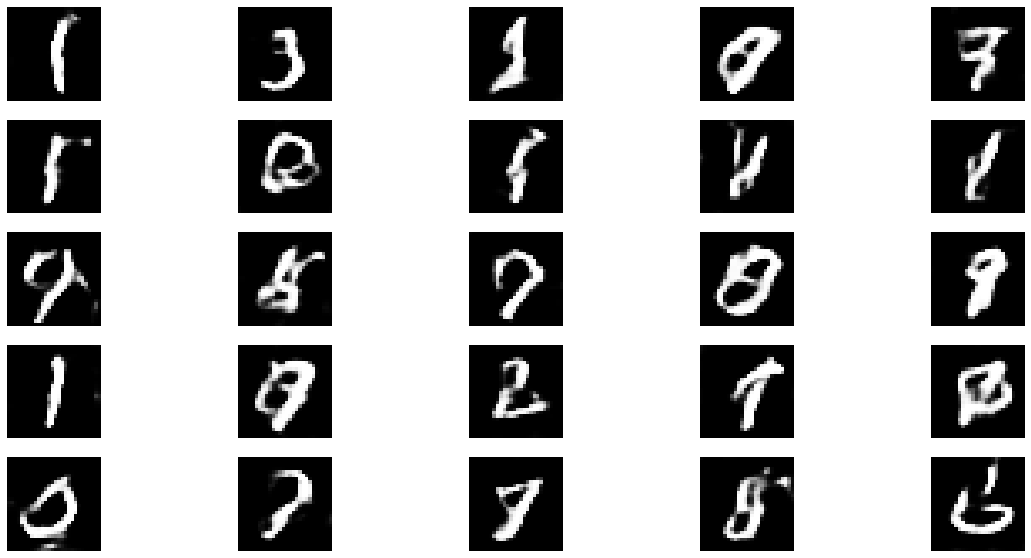

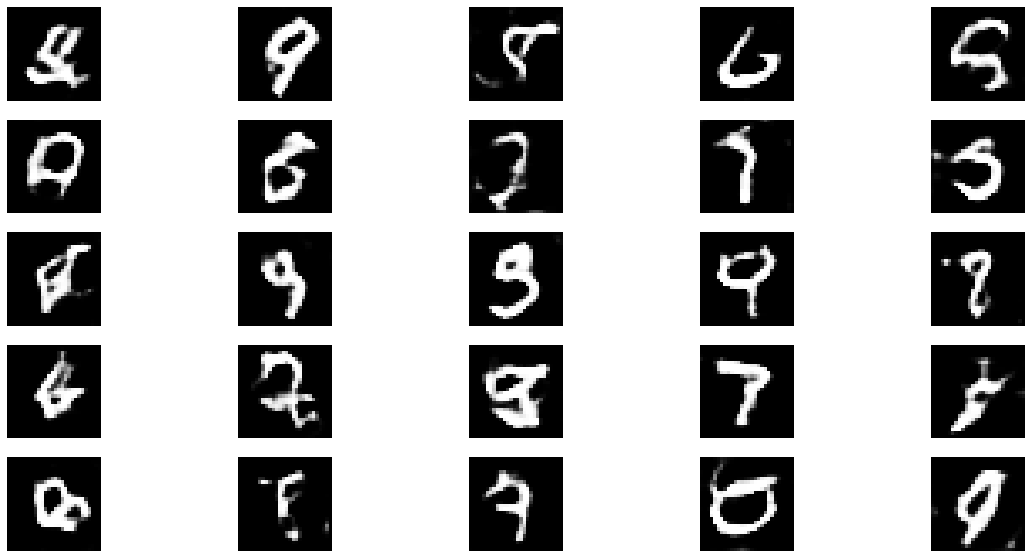

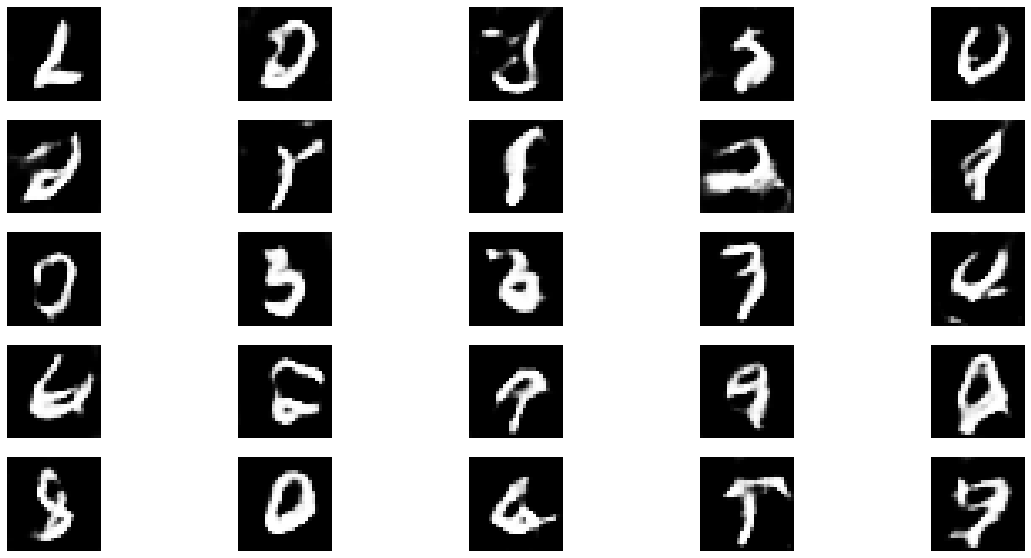

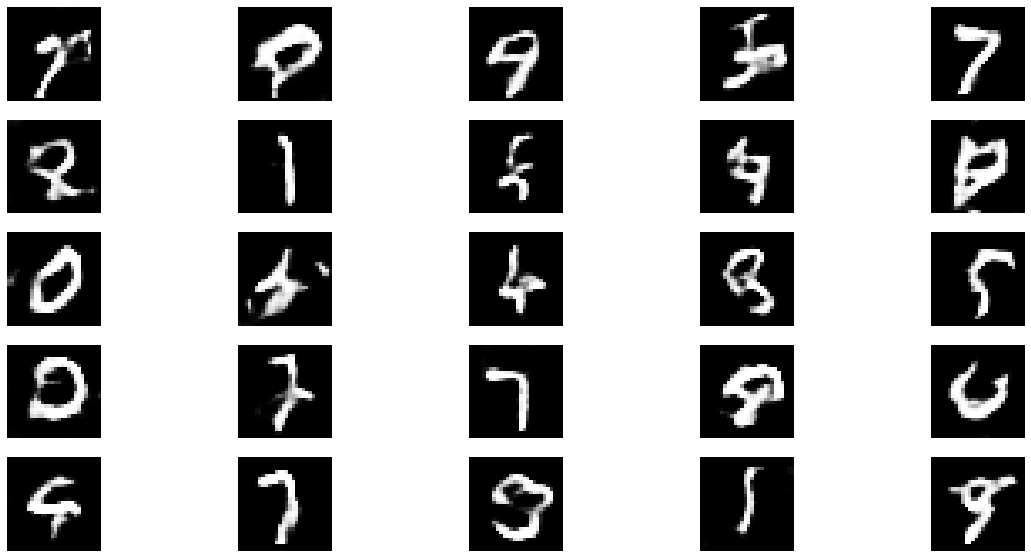

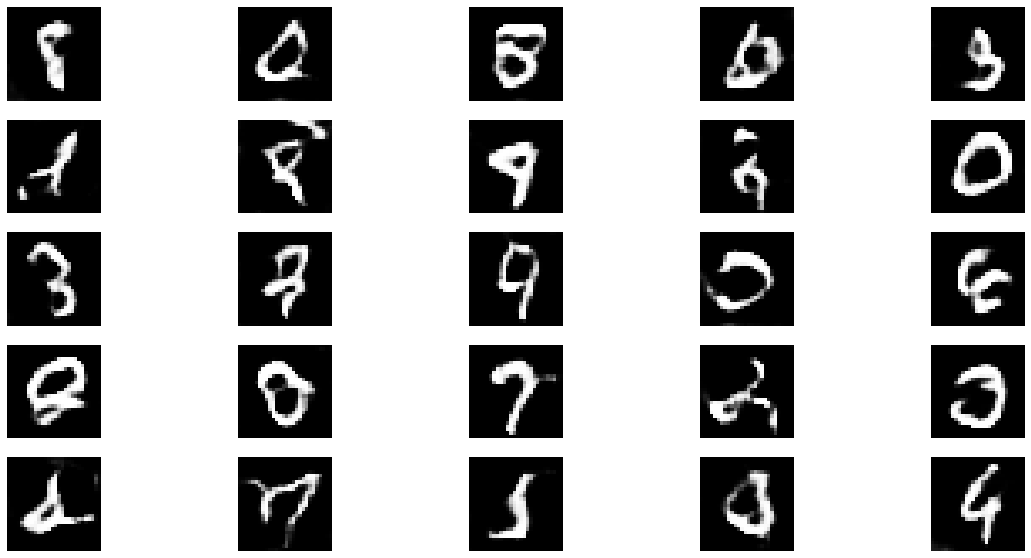

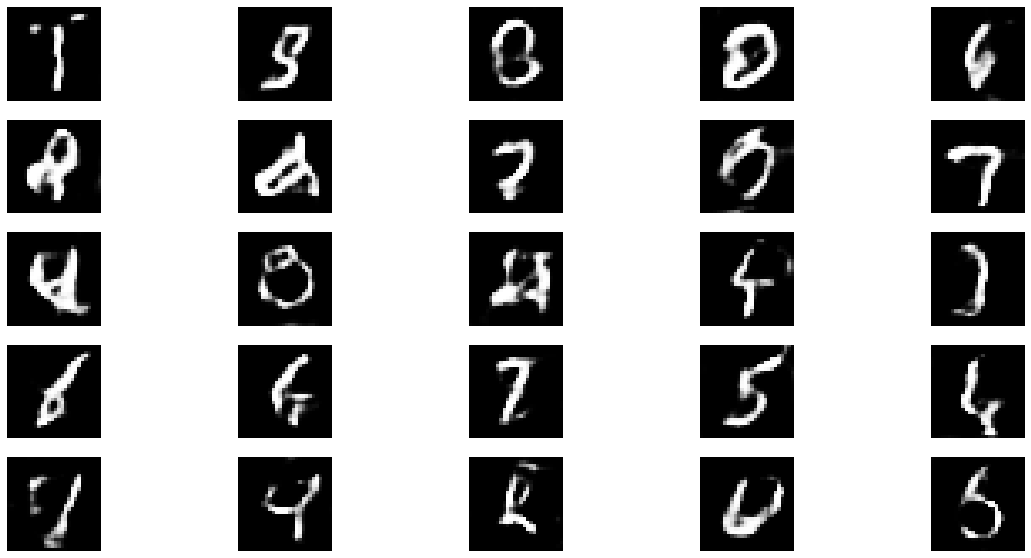

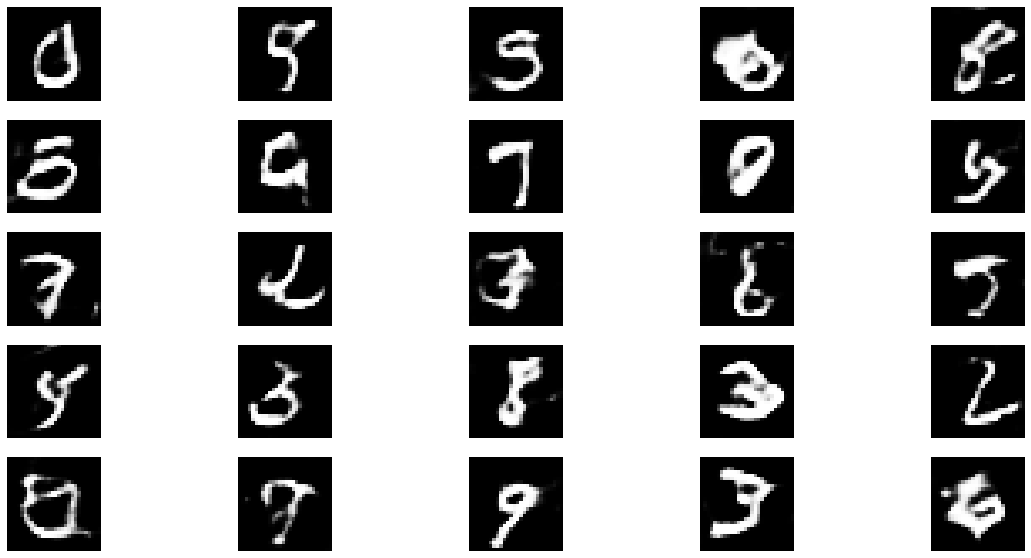

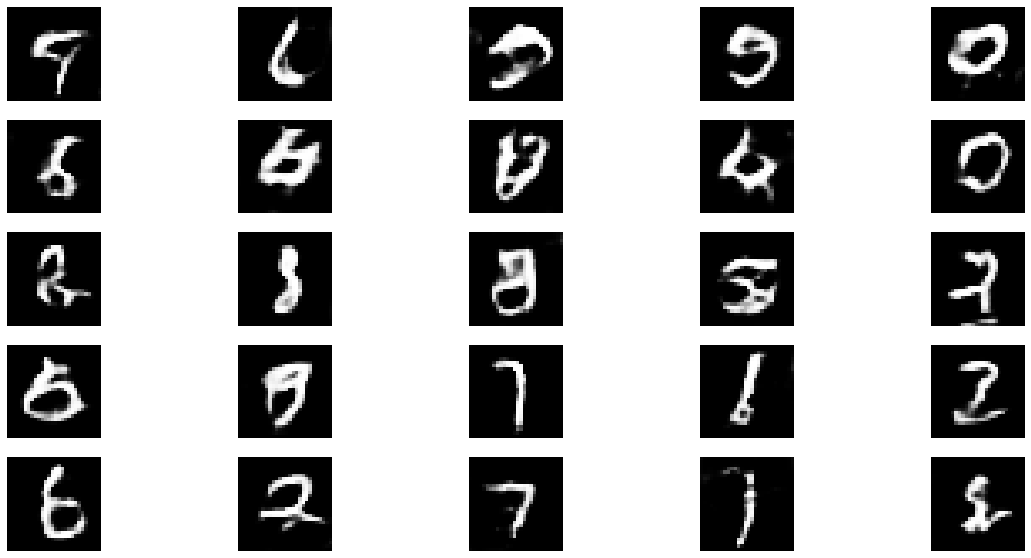

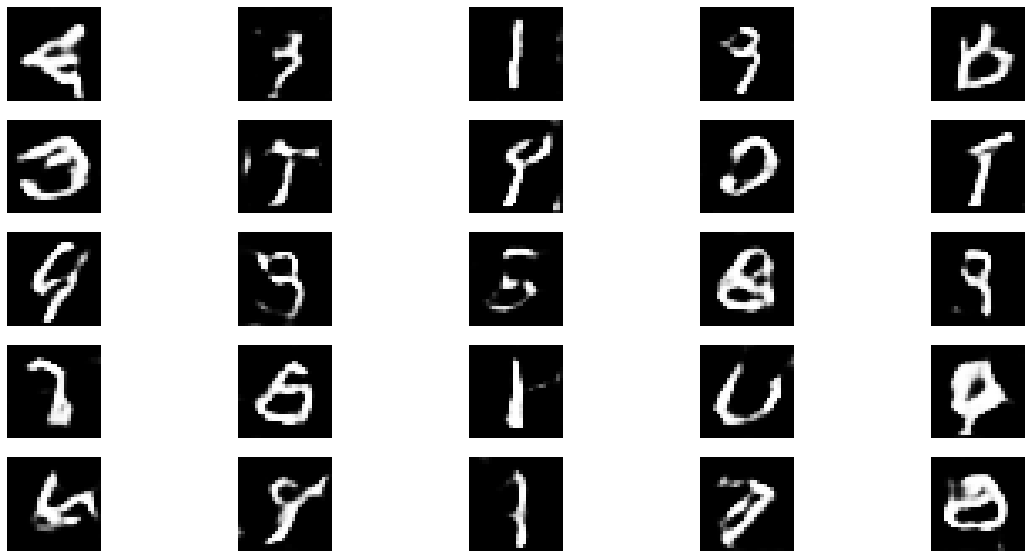

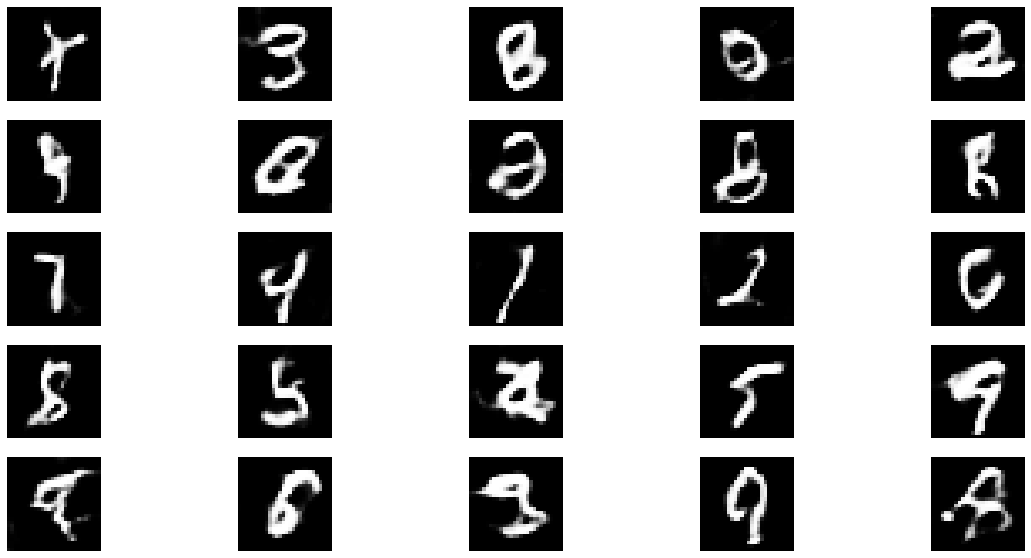

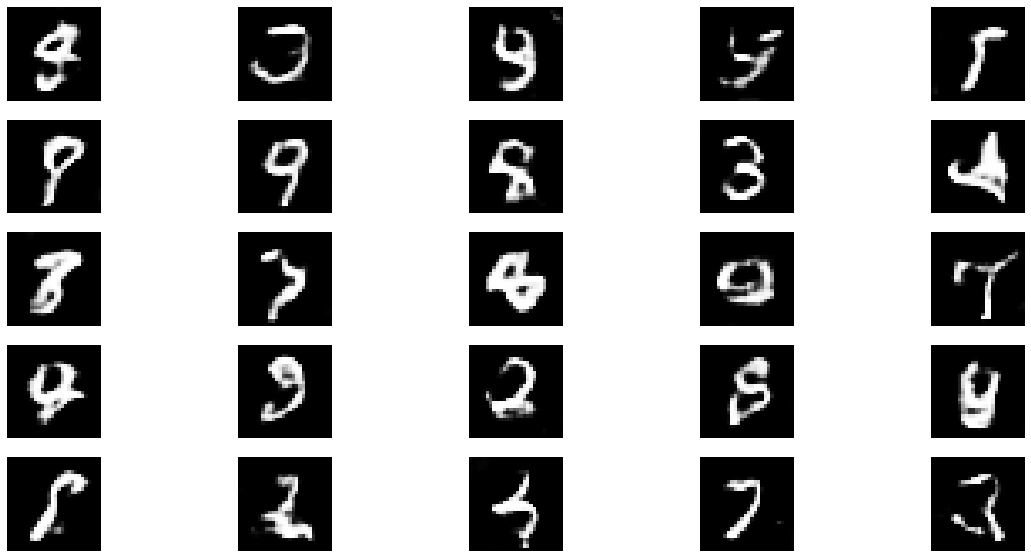

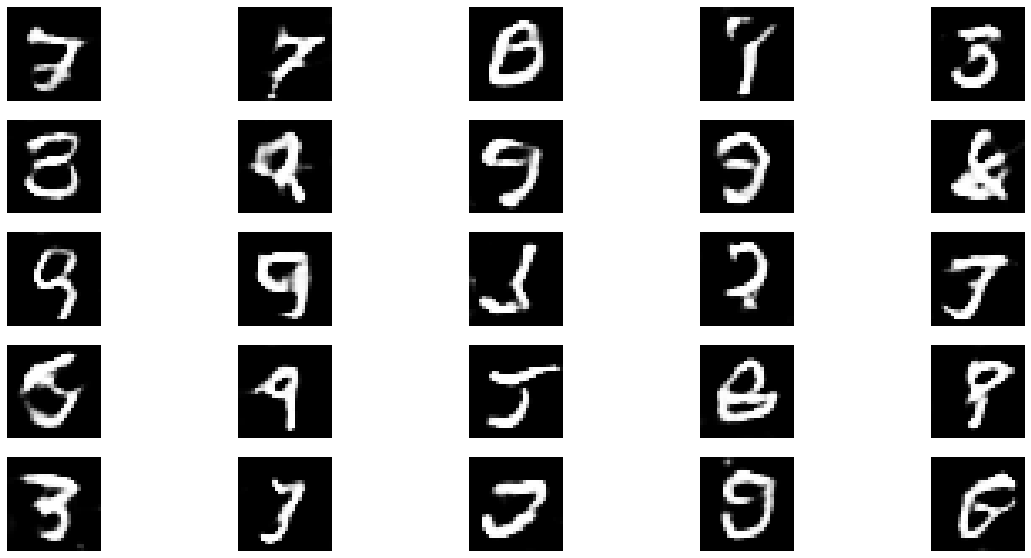

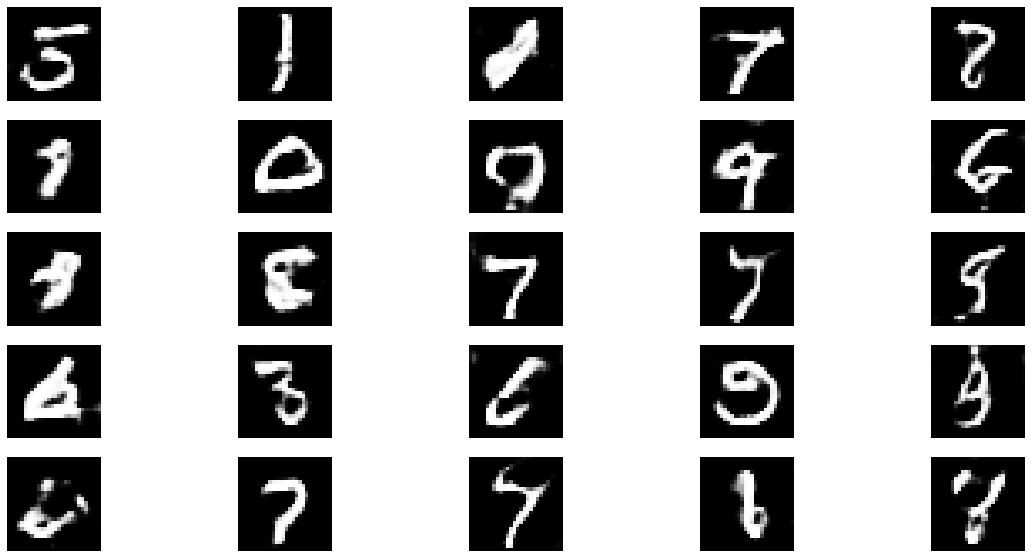

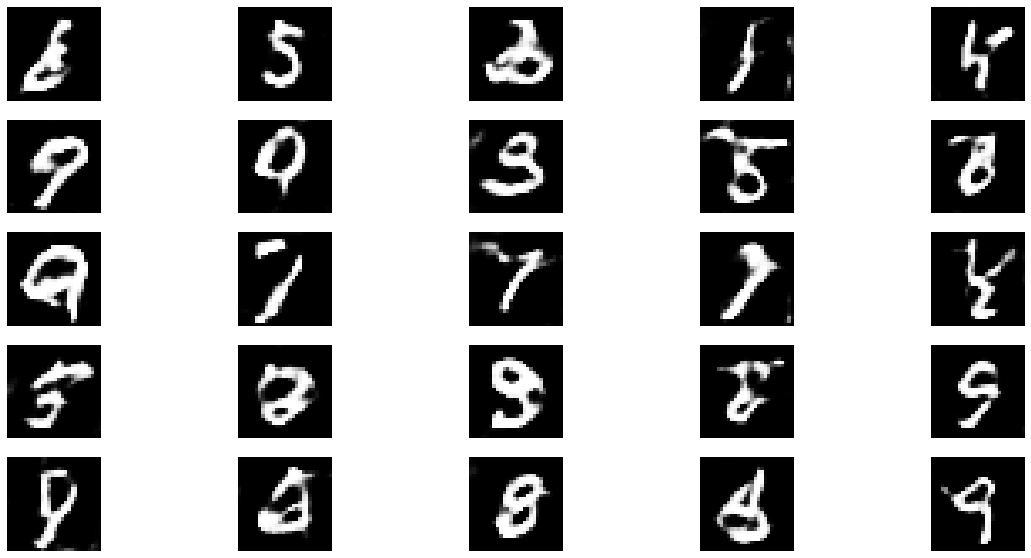

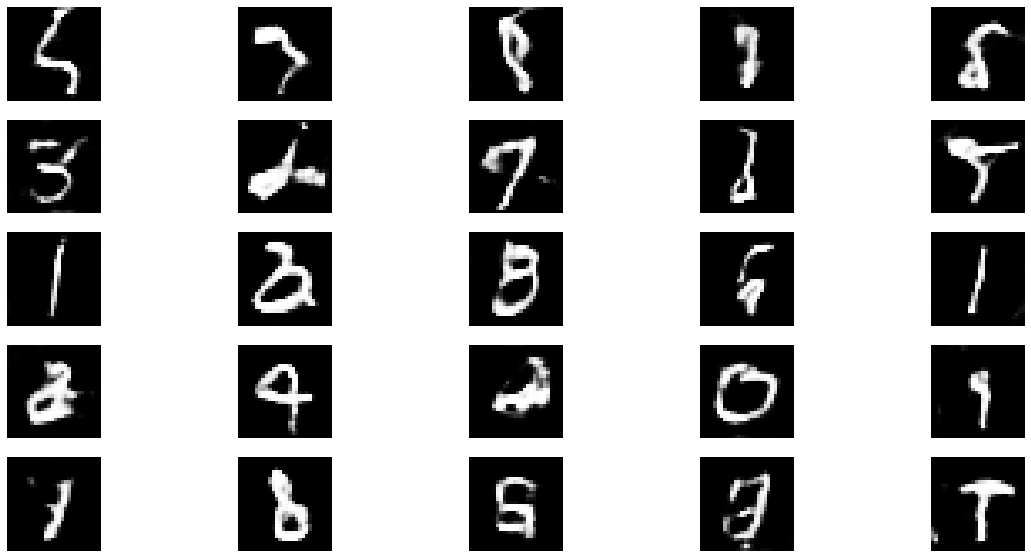

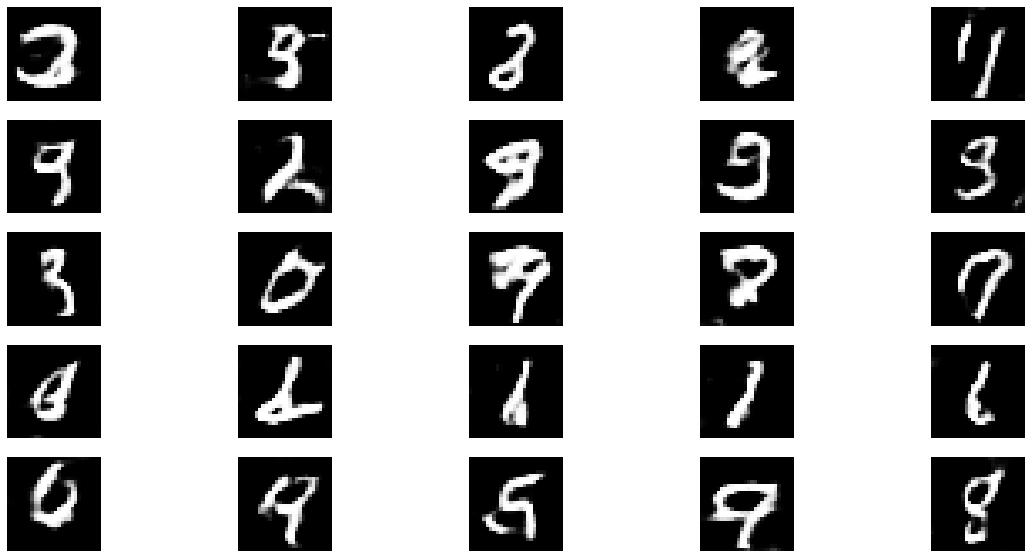

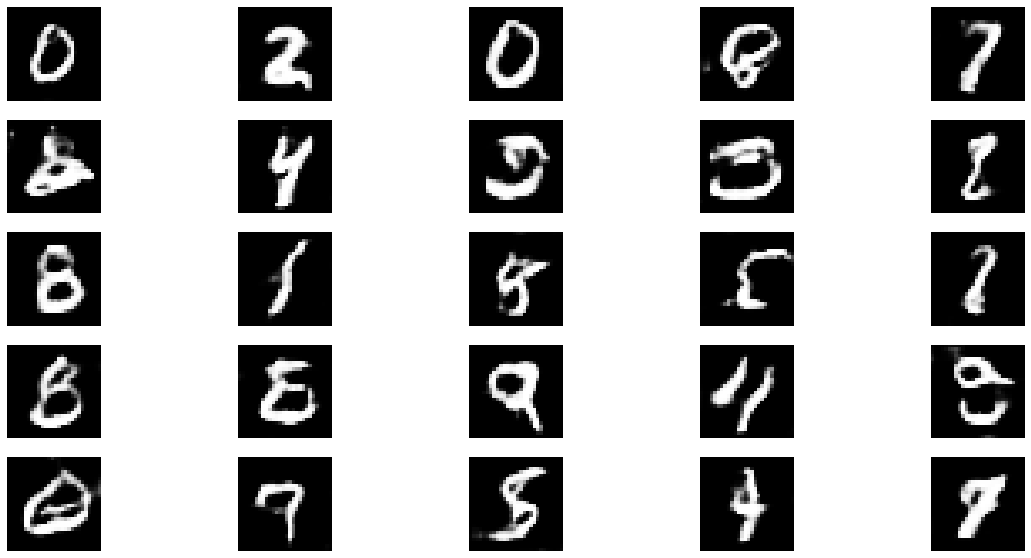

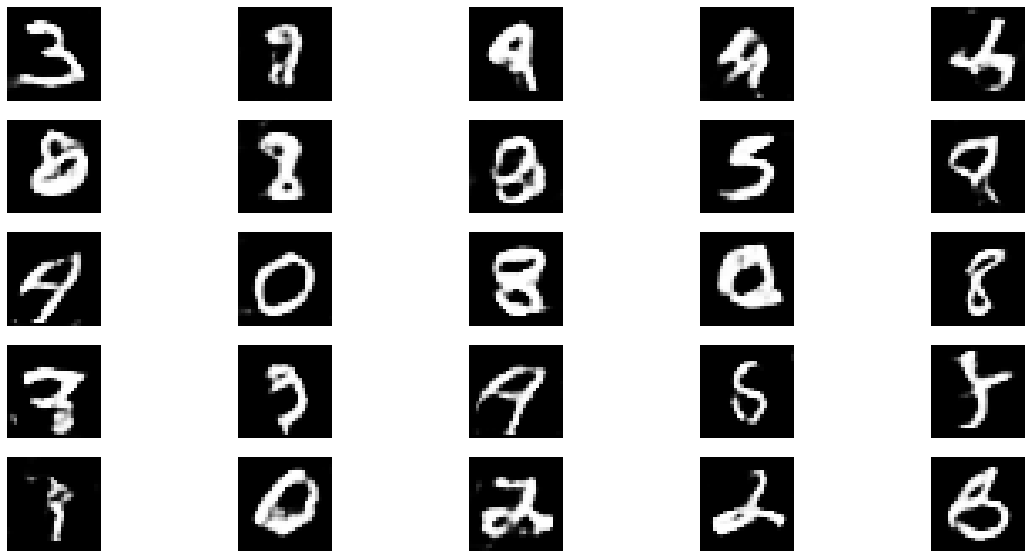

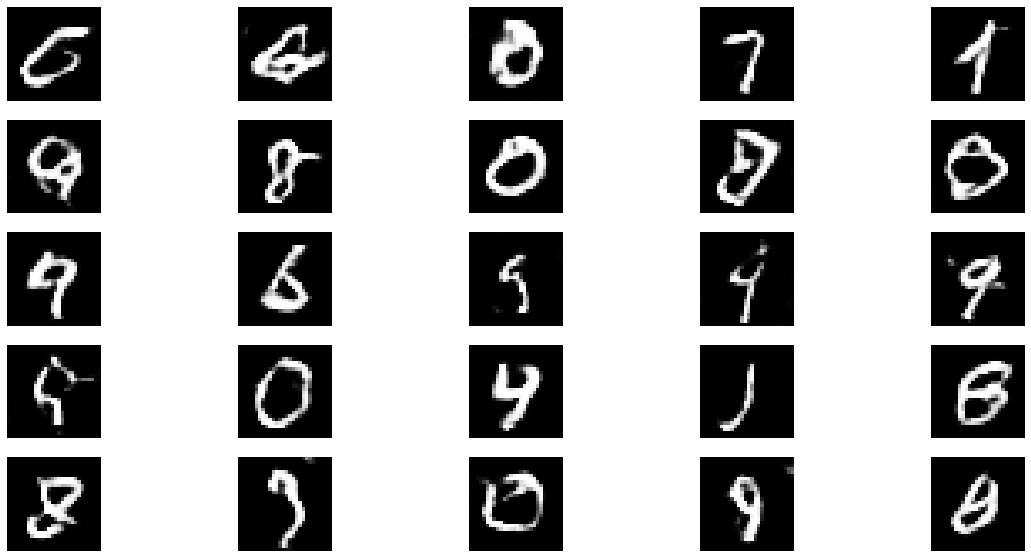

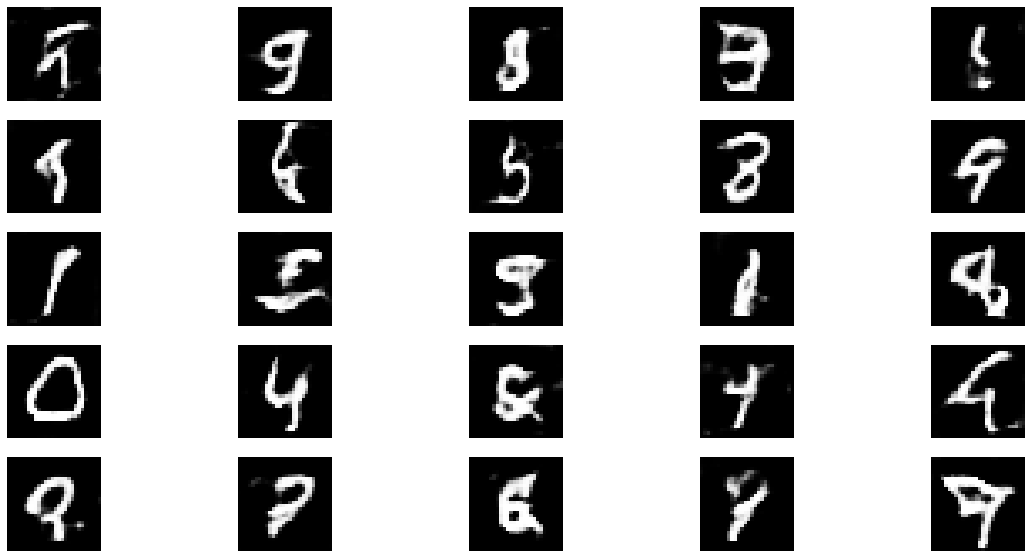

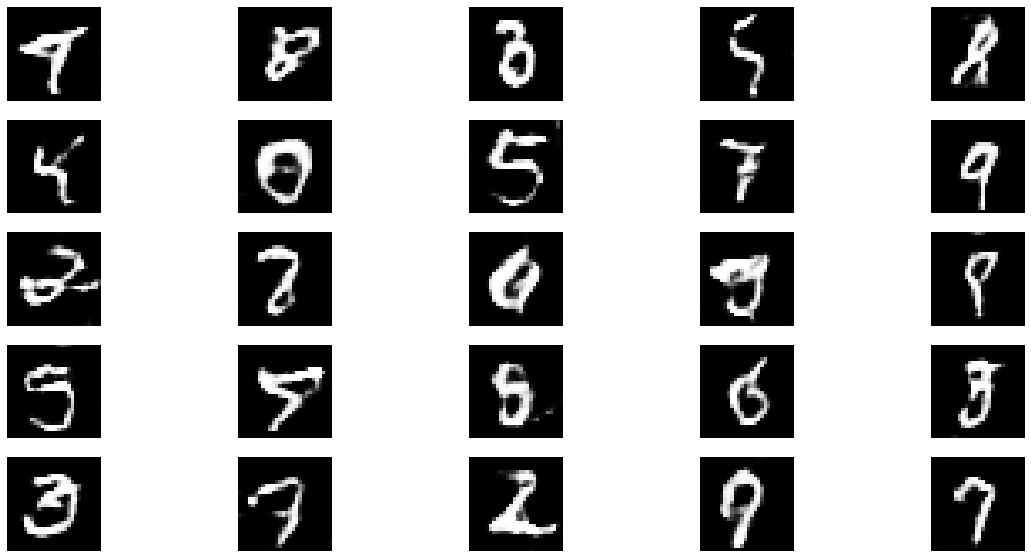

In [13]:
for i in range(4001) :
    # 실제 데이터를 판별자에 입력하는 부분
    idx = np.random.randint(0, X_train.shape[0], 32)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)
    # print(d_loss_real)
    
    # 가상 이미지를 판별자에 입력하는 부분
    noise = np.random.normal(0, 1, (32, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    # print(d_loss_fake)

    # 판별자와 생성자의 오차를 계산한다
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gen.train_on_batch(noise, true)
    
    print(f'epoch : {i}, d_loss = {d_loss}, g_loss : {g_loss}')
    
    # 200번 마다 한번씩 저장한다.
    if i % 200 == 0 :
        # 랜덤 이미지를 생성한다.
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)
        
        # 이미지 사이즈 조정
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        # 5 x 5 짜리 그래프 영역을 생성한다.
        fig, axs = plt.subplots(5, 5)
        
        count = 0 
        for j in range(5) :
            for k in range(5) :
                # 그래프 그리기
                axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[j, k].axis('off')
                count = count + 1
                
        # 파일로 저장
        fig.savefig(f'gan_image/gan_mnist_{i}.png')
